In [1]:
import math
import matplotlib.pyplot as plt
import random

import torch

import pennylane as qml
from pennylane import numpy as np
import sklearn
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cpu")

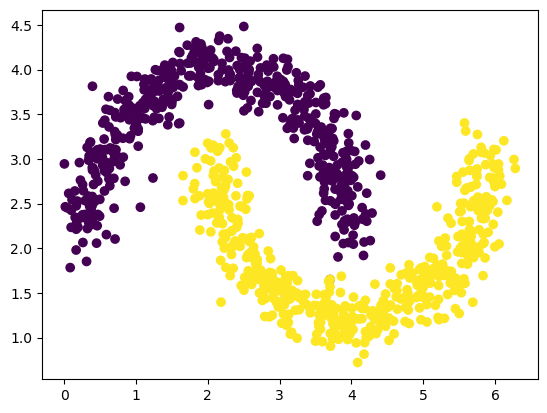

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons

# Generate and preprocess the dataset
dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
torch.set_default_dtype(dtype)
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:, None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:, None]).type(dtype).to(device)

# Visualize the dataset
X = dataset['train_input']
y = dataset['train_label']

x_min = torch.min(X)
x_max = torch.max(X)

X = (2*math.pi*(X - x_min)) / (x_max - x_min)

plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())
plt.show()


batch_size = 100
# g = torch.Generator().manual_seed(SEED)
train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True)


X_test = dataset['test_input']
Y_test = dataset['test_label']

x_min = torch.min(X_test)
x_max = torch.max(X_test)
X_test = (2*math.pi*(X_test - x_min)) / (x_max - x_min)

test_loader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size, shuffle=False)


In [3]:
n_qubits = 4
total_qubits = 4    ##### Change this to 8 if u want to use the ancillas
folds = 4
dev = qml.device("lightning.qubit", wires=total_qubits, c_dtype=np.complex64)

def strongly_entangling_layer(params, total_qubits=n_qubits):

    for i in range(total_qubits):
        qml.RY(params[i], wires=[i])
    for i in range(total_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[total_qubits - 1, 0])

def zz_featuremap(data_point):

    for i in range(len(data_point)):
        qml.Hadamard(wires=[i])
        qml.PhaseShift(2 * data_point[i], wires=[i])
    qml.CNOT(wires=[0,1])
    qml.PhaseShift(2 * (math.pi - data_point[0]) * (math.pi - data_point[1]), wires=1)
    qml.CNOT(wires=[0,1])

    
@qml.qnode(dev, interface="torch")
def circuit(data_point, params, folds=folds):
    # qml.AmplitudeEmbedding(features=data_point, wires=[0], pad_with=0., normalize=True)
    zz_featuremap(data_point)
    # qml.AngleEmbedding(features=data_point, wires=range(2), rotation="X")

    for i in range(folds):
        strongly_entangling_layer(params[i], total_qubits=n_qubits)

    output = qml.expval(qml.PauliZ(wires=[0]))

    return output

In [4]:
class BatchLossModel(torch.nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params

    def forward(self,x):
        outputs = torch.stack([circuit(x[i].cpu(), self.params.cpu()) for i in range(x.shape[0])])
        return outputs.to(device, dtype=dtype)

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.mps.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.mps.deterministc = True

def evaluate(model, data_loader):
    model.eval()
    batch_preds, batch_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:

            outputs = model(batch_x)
            pred = torch.sigmoid(outputs) > 0.5
            batch_preds.append(pred.cpu())
            batch_labels.append(batch_y.squeeze(1).cpu())

    batch_preds = torch.cat(batch_preds)
    batch_labels = torch.cat(batch_labels)
    accuracy = accuracy_score(batch_labels.numpy(), batch_preds.numpy())
    return accuracy

In [6]:
seeds = [0,42,123,2024,999]
max_accuracy_per_seed = []


for seed in seeds:
    set_seed(seed)
    weights = torch.rand((folds, total_qubits), requires_grad=True, dtype=dtype, device=device)
    model = BatchLossModel(weights)
    opt = torch.optim.Adam([weights],lr=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    best_test_accuracy = 0.000001

    for epoch in range(20):

        model.train()
        for batch_x, batch_y in train_loader:
            opt.zero_grad()
            circuit_outputs = (model(batch_x) + 1)/2
            loss = loss_fn(circuit_outputs, batch_y.squeeze(1))
            loss.backward()
            opt.step()
        
        test_acc = evaluate(model, test_loader)
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc

        print(f"seed {seed}: Epoch {epoch}; Test accuracy = {test_acc}")
    
    max_accuracy_per_seed.append(best_test_accuracy)

seed 0: Epoch 0; Test accuracy = 0.594
seed 0: Epoch 1; Test accuracy = 0.729
seed 0: Epoch 2; Test accuracy = 0.782
seed 0: Epoch 3; Test accuracy = 0.803
seed 0: Epoch 4; Test accuracy = 0.806
seed 0: Epoch 5; Test accuracy = 0.812
seed 0: Epoch 6; Test accuracy = 0.81
seed 0: Epoch 7; Test accuracy = 0.807
seed 0: Epoch 8; Test accuracy = 0.809
seed 0: Epoch 9; Test accuracy = 0.806
seed 0: Epoch 10; Test accuracy = 0.812
seed 0: Epoch 11; Test accuracy = 0.812
seed 0: Epoch 12; Test accuracy = 0.812
seed 0: Epoch 13; Test accuracy = 0.813
seed 0: Epoch 14; Test accuracy = 0.813
seed 0: Epoch 15; Test accuracy = 0.814
seed 0: Epoch 16; Test accuracy = 0.812
seed 0: Epoch 17; Test accuracy = 0.811
seed 0: Epoch 18; Test accuracy = 0.812
seed 0: Epoch 19; Test accuracy = 0.812
seed 42: Epoch 0; Test accuracy = 0.67
seed 42: Epoch 1; Test accuracy = 0.713
seed 42: Epoch 2; Test accuracy = 0.77
seed 42: Epoch 3; Test accuracy = 0.795
seed 42: Epoch 4; Test accuracy = 0.796
seed 42: Epoc

In [7]:
print(f"Mean of Best Test Accuracies for diff seeds: {np.mean(max_accuracy_per_seed)}")

Mean of Best Test Accuracies for diff seeds: 0.8121999999999998


Mean of max test_accuracies for different seeds -

1. Amplitude Embedding - No Ancillas:  0.8478

2. Amplitude Embedding - With Ancillas:  0.8396

3. Angle Embedding : 0.8018

4. ZZ Feature Map: 0.8121